In [1]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from tripletnet import Tripletnet
from type_specific_network import TypeSpecificNet
from PIL import Image
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.__version__

'0.1.12_2'

In [4]:
datadir = "./data"

In [5]:
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=5e-5, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=250, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default='', type=str,
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--name', default='Type_Specific_Fashion_Compatibility', type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=False,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=False,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=False,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=False,
                    help='To initialize masks to be disjoint')
parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=False,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=0.3, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')

_StoreAction(option_strings=['--sim_i_loss'], dest='sim_i_loss', nargs=None, const=None, default=5e-05, type=<type 'float'>, choices=None, help='parameter for loss for image-image similarity', metavar='M')

In [6]:
global args
args = parser.parse_args(args=['--test', "--l2_embed", "--resume", "runs/nondisjoint_l2norm/model_best.pth.tar"])
args.cuda = False #not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

In [7]:
args.datadir=datadir

In [8]:
args.resume

'runs/nondisjoint_l2norm/model_best.pth.tar'

In [9]:
df = pd.read_csv("typespaces.csv")

In [10]:
del df["Unnamed: 0"]

In [11]:
keys = df['0'].values
values = df['1'].values

In [12]:
typespaces=dict(zip(keys,values))
text_feature_dim = 6000

In [13]:
model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
csn_model = TypeSpecificNet(args, model, len(typespaces))

criterion = torch.nn.MarginRankingLoss(margin = args.margin)
tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)

In [16]:
if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume, map_location=lambda storage, loc: storage)
        args.start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_prec1']
        tnet.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(args.resume, checkpoint['epoch']))
else:
        print("=> no checkpoint found at '{}'".format(args.resume))

=> loading checkpoint 'runs/nondisjoint_l2norm/model_best.pth.tar'
=> loaded checkpoint 'runs/nondisjoint_l2norm/model_best.pth.tar' (epoch 5)


In [27]:
old_codes = [
 'null',
 'bag',
 'belt',
 'boots',
 'footwear',
 'outer',
 'dress',
 'sunglasses',
 'pants',
 'top',
 'shorts',
 'skirt',
 'headwear',
 'scarf & tie']

new_codes = ['tops',
 'shoes',
 'all-body',
 'scarves',
 'outerwear',
 'accessories',
 'hats',
 'bags',
 'bottoms',
 'sunglasses']

matches = {
 'bag':'bags',
 'belt':'accessories',
 'boots':'shoes',
 'footwear':'shoes',
 'outer':'outerwear',
 'dress':'all-body',
 'sunglasses':'sunglasses',
 'pants':'bottoms',
 'top':'tops',
 'shorts':'bottoms',
 'skirt':'bottoms',
 'headwear':'hats',
 'scarf & tie':'scarves'}

old_code_to_new_and_name = {i + 1 : (new_codes.index(matches[name]) + 1, matches[name]) for i, name in enumerate(old_codes[1:])}

def get_parts_by_mask(img, mask_true):
    mask = np.copy(mask_true)
    mask_ = np.copy(mask)
    for key, value in old_code_to_new_and_name.items():
        #if key == 7:
        #   print(value)
        mask[mask_==key] = value[0]
    classes = set(mask.flatten())
    #print(classes)
    resized_mask = np.round(np.array(Image.fromarray(np.uint8(mask), 'L').resize(reversed(img.shape[:2]))))
    classes = list(set(mask.flatten()))
    if 0 in classes:
        classes.remove(0)
    #print('classes:', classes)
    final_imgs = []
    for cls in classes:
        #print(cls, new_codes[cls - 1])
        curr_mask = (resized_mask == cls) * 1.
        new_img = np.zeros(img.shape)
        new_img[:, :, 0] = np.multiply(img[:, :, 0], curr_mask)
        new_img[:, :, 1] = np.multiply(img[:, :, 1], curr_mask)
        new_img[:, :, 2] = np.multiply(img[:, :, 2], curr_mask)
        new_img[new_img==0] = 255.
        new_img = new_img.astype(np.uint8)
        axis0 = np.where(curr_mask.sum(axis=0) > 0)[0]
        axis1 = np.where(curr_mask.sum(axis=1) > 0)[0]
        min_x, max_x = min(axis0), max(axis0)
        min_y, max_y = min(axis1), max(axis1)
        new_img = new_img[min_y : max_y, min_x : max_x]
        N, M, _ = new_img.shape
        d = int(max(N, M) / 10)
        D = max(N, M) + 2 * d
        img_to_reshape = np.ones((D, D, 3)) * 255.
        if N > M:
            y = d + int((D - M) / 2)
            img_to_reshape[d:N + d, y - d:y - d + M, :] = new_img
        else:
            x = d + int((D - N) / 2)
            img_to_reshape[x - d : x - d + N, d : M + d] = new_img
        img_to_reshape = img_to_reshape.astype(np.uint8)
        sized_img = Image.fromarray(img_to_reshape).resize((112, 112))
        final_imgs.append((sized_img, new_codes[cls - 1]))
    return final_imgs

In [18]:
old_code_to_new_and_name

{1: (8, 'bags'),
 2: (6, 'accessories'),
 3: (2, 'shoes'),
 4: (2, 'shoes'),
 5: (5, 'outerwear'),
 6: (3, 'all-body'),
 7: (10, 'sunglasses'),
 8: (9, 'bottoms'),
 9: (1, 'tops'),
 10: (9, 'bottoms'),
 11: (9, 'bottoms'),
 12: (7, 'hats'),
 13: (4, 'scarves')}

In [20]:
im = Image.open("/Users/nikitakaraev/Desktop/PROJET_DEEP_LEARNING/FACEBOOKHACK/0000731.jpg")

In [21]:
mask=Image.open("/Users/nikitakaraev/Desktop/PROJET_DEEP_LEARNING/FACEBOOKHACK/0000731.png")

In [22]:
imarr=np.array(im)
maskarr=np.array(mask).squeeze()

In [23]:
imarr.shape

(600, 400, 3)

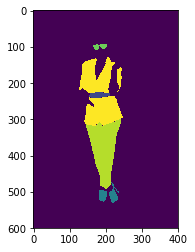

In [24]:
plt.imshow(maskarr)

In [25]:
maskarr.shape

(600, 400)

In [28]:
cloth_images = get_parts_by_mask(imarr, maskarr)

In [29]:
cloth_images

[(<PIL.Image.Image image mode=RGB size=112x112 at 0x10D0CD650>, 'tops'),
 (<PIL.Image.Image image mode=RGB size=112x112 at 0x10B46D810>, 'shoes'),
 (<PIL.Image.Image image mode=RGB size=112x112 at 0x10B46D710>, 'accessories'),
 (<PIL.Image.Image image mode=RGB size=112x112 at 0x10B46D9D0>, 'bottoms'),
 (<PIL.Image.Image image mode=RGB size=112x112 at 0x10B46DA10>, 'sunglasses')]

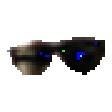

In [34]:
cloth_images[4][0]

In [35]:
torch.manual_seed(1)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform=transforms.Compose([
     transforms.ToTensor(),
     normalize
])

In [36]:
transformedImage = transform(cloth_images[0][0])

In [37]:
ims=Variable(transformedImage); ims

Variable containing:
( 0 ,.,.) = 
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
           ...             ⋱             ...          
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489

( 1 ,.,.) = 
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
           ...             ⋱             ...          
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286

( 2 ,.,.) = 
  2.6400  2.6400  2.6400  ...   2.6400  2.6400  2.6400
  2.6400  2.6400  2.6400  ...   2.6400  2.6400  2.6400
  2.6400  2.6400  2.6400  ...   2.6400  2.6400  2.6400
   

In [38]:
cudnn.benchmark = True    

In [39]:
tnet.eval();

In [41]:
embedding = tnet.embeddingnet(ims.unsqueeze(0)).data

In [42]:
embedding.size()

torch.Size([1, 67, 64])